# Lab 2

## Task 4

## Reporter: Polyakov Gregory

### Description: 

Reimplement experiment from the article ["Variational Inference with Gradient Flows"](http://approximateinference.org/accepted/AltieriDuvenaud2015.pdf). Compare the results with the results from article and vanilla VAE.


### Theory:

Variational autoencoder optimizes ELBO:

$$\log p(x) \geq \mathcal{H}[q(z|x)] + \mathbb{E}_{q(z|x)} \log p(x, z)$$

Where $\mathcal{H}[q(z|x)]$ -- entropy of conditional distribution (modeled by encoder) of latent variable $Z$ with respect to obsevable sample $X$.

$$Z \sim \mathcal{N}(\mu, \Sigma) \Rightarrow \mathcal{H} = D \log |\Sigma| + \frac{D}{2}(1 + \log 2\pi) = \mathcal{L}[q]$$

$p(x, z) = p(x|z) \cdot q(z)$ -- joint distribution of latent variable and $x$.
$q(z) \sim \mathcal{N}(0, I)$ -- latent variable prior. $p(x|z)$ -- conditional distribution (modeled by decoder) of $X$ with respect to latent variable $Z$.

We are using binarized MNIST. 

Let $\xi$ be logits of the decoder. Than $X$ - multivariate random Bernoulli random variable with mean $\xi$. 
$$p(x, z) = \prod_{i=1}^D \xi_i^{x_i}(1 - \xi_i)^{(1 - x_i)} \Rightarrow $$
$$\Rightarrow \log p(x, z) = \sum_{i=1}^D (x_i \log \xi_i + (1 - x_i) \log (1 - \xi_i)) \text{ -- negative cross entropy between logits and observation}$$

We'd like to augment this procedure with several gradient ascend steps to maximize ELBO even better.

Given observable value of latent variable $z_0$, take several steps: 
$$z_{t+1} = z_t + \alpha \nabla \log p(x, z_t)$$

Also after gradient ascend steps we don't know latent varable distribution parameters. So, we'll calculate entropy as 
$$\mathcal{H}[q_{t+1}] - \mathcal{H}[q_{t}] = \log |J(q_t)| = \log |I - \alpha H_t|$$

$J$ - jacobian, $H$ - hessian

Output ELBO (expectation will be approximated by monte-carlo sampling):

$$ \mathcal{L}[q_T] \approx \log p(z_T, x) + \sum_{t=0}^T \log |J(z_T)| + \mathcal{H}[q_0]$$

Jacobian approxiamtion:
Algorithm is taken from the article [Early Stopping is Nonparametric Variational Inference](https://arxiv.org/pdf/1504.01344.pdf) (Algorithm 2).

### Code:

Some parts of naive-VAE implementation were taken from the [official jax documentation](https://github.com/google/jax/blob/main/examples/mnist_vae.py)
Mnist was downloaded also by the [script from tutorials](https://github.com/google/jax/blob/main/examples/datasets.py)

In [58]:
import os
import time

import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import jit, grad, lax, random, hessian
from jax.example_libraries import optimizers
from jax.example_libraries import stax
from optax import sigmoid_binary_cross_entropy
from jax.example_libraries.stax import Dense, FanOut, Relu, Softplus
import matplotlib.pyplot as plt
from jax.scipy.stats import multivariate_normal
import datasets

LOG_STEP = 20
STEP_SIZE = 1e-4
NUM_EPOCHS = 100
BATCH_SIZE = 100
TEST_RNG = random.PRNGKey(1)

FLOW_STEPS = 3
ALPHA = 1e-3

#### Loading data

In [18]:
# Downloading train data
train_images, _, test_images, _ = datasets.mnist(permute_train=True)
print(f'Train shape: {train_images.shape}')

Train shape: (60000, 784)


#### Defining necessary functions

In [93]:
def gaussian_sample(rng, mu, sigmasq):
    '''
    Samples random variable from multivariate 
    normal distribution given mean and cov.
    '''
    return mu + jnp.sqrt(sigmasq) * random.normal(rng, mu.shape)


def gaussian_entropy(sigmasq):
    '''Entropy of standart multivariate normal'''
    return 0.5 * (jnp.sum(jnp.log(sigmasq))
                  + sigmasq.shape[-1] * (1 + jnp.log(2 * jnp.pi)))


def logpdf(logits, x, z):
    '''
    Loagirthm of joint distribution density function
    log p(x, z) = log p(x|z) + log q(z)
    '''
    condition = -jnp.sum(sigmoid_binary_cross_entropy(logits, jnp.where(x, 1., 0.)))
    prior_mean = jnp.zeros(z.shape[-1])
    prior_cov = jnp.diag(jnp.ones(z.shape[-1]))
    prior = jnp.sum(multivariate_normal.logpdf(z, mean=prior_mean, cov=prior_cov))
    return condition + prior


def hvp(f, z, v):
    '''Hessian vector product for jacobian estimation'''
    return grad(lambda x: jnp.vdot(grad(f)(x), v))(z)


def log_jacobian_estimate(f, z, r_0):
    '''
    Logarithm of jacobian estimation
    '''
    r_1 = r_0 - ALPHA * hvp(f, z, r_0)
    r_2 = r_1 - ALPHA * hvp(f, z, r_1)
    return jnp.vdot(r_0, -2 * r_0 + 3 * r_1 - r_2)


def elbo_grad_flow(rng, jacob_rng, params, images):
    '''Computation of ELBO with several steps of gradient flow'''
    enc_params, dec_params = params
    mu_z, sigmasq_z = encode(enc_params, images)

    curr_z = gaussian_sample(rng, mu_z, sigmasq_z)
    curr_entropy = gaussian_entropy(sigmasq_z)

    jacob_init_r = gaussian_sample(jacob_rng, mu_z, sigmasq_z)
    logpdf_func = lambda z: logpdf(decode(dec_params, z), images, z)
    for j in range(FLOW_STEPS):
        curr_entropy += log_jacobian_estimate(logpdf_func, curr_z, jacob_init_r)
        curr_z += ALPHA * grad(logpdf_func)(curr_z)

    return logpdf_func(curr_z) + curr_entropy


def inference(rng, jacob_rng, params, image, grad_flow=False):
    '''Reconstruction of image from the original one'''
    enc_params, dec_params = params
    
    mu_z, sigmasq_z = encode(enc_params, image)
    curr_z = gaussian_sample(rng, mu_z, sigmasq_z)
    
    if grad_flow:
        logpdf_func = lambda z: logpdf(decode(dec_params, z), image, z)
        for j in range(FLOW_STEPS):
            curr_z += ALPHA * grad(logpdf_func)(curr_z)
    
    return decode(dec_params, curr_z)
    

def elbo(rng, jacob_rng, params, images):
    '''Naive VAE ELBO computation'''
    enc_params, dec_params = params
    mu_z, sigmasq_z = encode(enc_params, images)
    z = gaussian_sample(rng, mu_z, sigmasq_z)
    logits_x = decode(dec_params, z)
    return logpdf(logits_x, images, z) + gaussian_entropy(sigmasq_z)

#### Defining model architecture

In [22]:
# MLP definitions
encoder_init, encode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    FanOut(2),
    stax.parallel(Dense(10), stax.serial(Dense(10), Softplus)),
)

decoder_init, decode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    Dense(28 * 28),
)

In [23]:
# transfering data to GPU
train_images = jax.device_put(train_images)
test_images = jax.device_put(test_images)

In [14]:
num_complete_batches, leftover = divmod(train_images.shape[0], BATCH_SIZE)
num_batches = num_complete_batches + bool(leftover)

#### Train-evaluate pipeline

In [15]:
def binarize_batch(rng, i, images):
    '''We train our VAE on binarized MNIST'''
    i = i % num_batches
    batch = lax.dynamic_slice_in_dim(images, i * BATCH_SIZE, BATCH_SIZE)
    return random.bernoulli(rng, batch)

def run_epoch(rng, opt_state, images, grad_flow):
    def body_fun(i, opt_state):
        elbo_rng, data_rng, jacob_rng = random.split(random.fold_in(rng, i), 3)
        batch = binarize_batch(data_rng, i, images)
        if grad_flow:
            loss = lambda params: -elbo_grad_flow(elbo_rng, jacob_rng, params, batch) / BATCH_SIZE
        else:
            loss = lambda params: -elbo(elbo_rng, jacob_rng, params, batch) / BATCH_SIZE
        g = grad(loss)(get_params(opt_state))
        return opt_update(i, g, opt_state)
    return lax.fori_loop(0, num_batches, body_fun, opt_state)

def evaluate(opt_state, images, grad_flow):
    params = get_params(opt_state)
    elbo_rng, jacob_rng, data_rng, image_rng = random.split(TEST_RNG, 4)
    binarized_test = random.bernoulli(data_rng, images)

    if grad_flow:
        test_elbo = elbo_grad_flow(elbo_rng, jacob_rng, params, binarized_test) / images.shape[0]
    else:
        test_elbo = elbo(elbo_rng, jacob_rng, params, binarized_test) / images.shape[0]
    return test_elbo

#### Training naive VAE and VAE with gradient ascend augmentation

In [57]:
# initailizating weights and hyperparameters
enc_init_rng, dec_init_rng = random.split(random.PRNGKey(2))
_, init_encoder_params = encoder_init(enc_init_rng, (BATCH_SIZE, 28 * 28))
_, init_decoder_params = decoder_init(dec_init_rng, (BATCH_SIZE, 10))
init_params = init_encoder_params, init_decoder_params

opt_init, opt_update, get_params = optimizers.adam(STEP_SIZE)
opt_state_naive = opt_init(init_params)

#train loop
elbos = []
for epoch in range(NUM_EPOCHS):
    tic = time.time()
    opt_state_naive = run_epoch(random.PRNGKey(epoch), opt_state_naive, train_images, grad_flow=False)
    test_elbo = evaluate(opt_state_naive, test_images, grad_flow=False)
    elbos.append(test_elbo)
    if (epoch + 1) % LOG_STEP == 0:
        print(f"{(epoch + 1): 3d} {test_elbo} ({time.time() - tic:.3f} sec)")

 20 -134.04637145996094 (1.300 sec)
 40 -127.23532104492188 (1.300 sec)
 60 -123.99864196777344 (1.296 sec)
 80 -121.95693969726562 (1.285 sec)
 100 -120.49928283691406 (1.292 sec)


In [30]:
# initailizating weights and hyperparameters
enc_init_rng, dec_init_rng = random.split(random.PRNGKey(2))
_, init_encoder_params = encoder_init(enc_init_rng, (BATCH_SIZE, 28 * 28))
_, init_decoder_params = decoder_init(dec_init_rng, (BATCH_SIZE, 10))
init_params = init_encoder_params, init_decoder_params

opt_init, opt_update, get_params = optimizers.adam(STEP_SIZE)
opt_state = opt_init(init_params)

#train loop
elbos_grad_flow = []
for epoch in range(NUM_EPOCHS):
    tic = time.time()
    opt_state = run_epoch(random.PRNGKey(epoch), opt_state, train_images, grad_flow=True)
    test_elbo = evaluate(opt_state, test_images, grad_flow=True)
    elbos_grad_flow.append(test_elbo)
    if (epoch + 1) % LOG_STEP == 0:
        print(f"{(epoch + 1): 3d} {test_elbo} ({time.time() - tic:.3f} sec)")

 20 -131.54287719726562 (9.119 sec)
 40 -122.62638092041016 (9.278 sec)
 60 -119.34474182128906 (9.038 sec)
 80 -116.3571548461914 (9.089 sec)
 100 -113.30575561523438 (9.288 sec)


#### ELBO on test set

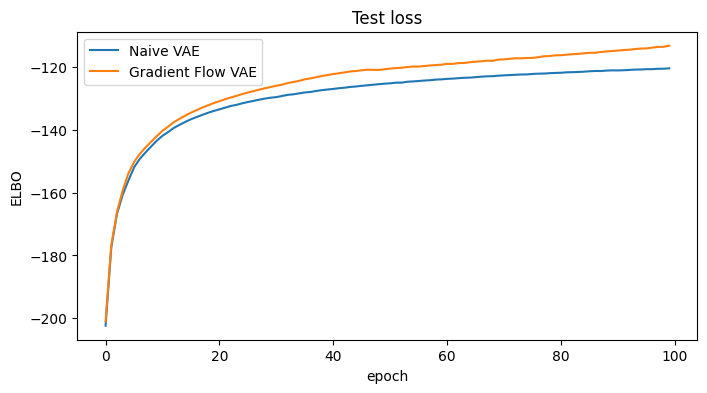

In [94]:
plt.figure(figsize=(8, 4))

plt.plot(jnp.arange(len(elbos)), elbos, label='Naive VAE')
plt.plot(jnp.arange(len(elbos_grad_flow)), elbos_grad_flow, label='Gradient Flow VAE')

plt.title('Test loss')
plt.xlabel('epoch')
plt.ylabel('ELBO')
plt.legend()

plt.show()

#### Some examples

In [95]:
test_image = test_images[0]
elbo_rng, jacob_rng = random.split(TEST_RNG, 2)
reconstructed_naive = jax.nn.sigmoid(inference(elbo_rng, jacob_rng,
                                               get_params(opt_state_naive), test_image))
reconstructed_grad_flow = jax.nn.sigmoid(inference(elbo_rng, jacob_rng,
                                                   get_params(opt_state), test_image, grad_flow=True))

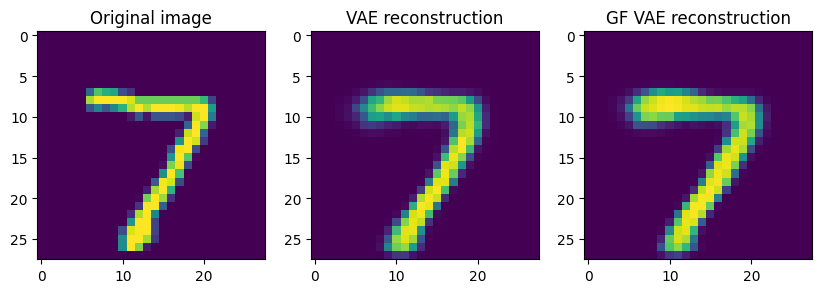

In [96]:
plt.figure(figsize=(10, 3))

plt.subplot(131)
plt.imshow(test_image.reshape((28, 28)))
plt.title('Original image')
plt.subplot(132)
plt.imshow(reconstructed_naive.reshape((28, 28)))
plt.title('VAE reconstruction')
plt.subplot(133)
plt.imshow(reconstructed_grad_flow.reshape((28, 28)))
plt.title('GF VAE reconstruction')

plt.show()

#### Conclusion

As we can see on test ELBO plot, variational autoencoder performs better than the original one. Thus, we reproduced results from the original article.

Visually, the third image is a little more similar to the original. However, the considered examples of image reconstruction do not show strong differences between naive VAE and VAE with gradient ascend. This could be due to simpleness of MNIST dataset or simpleness of considered backbone network architecture.